In [1]:
import numpy as np
import pandas as pd
import nbimporter
import dynamicalModels as dynamicalModels
import statsmodels.api as sm
from statsmodels.tsa.api import VAR, DynamicVAR
from statsmodels.tsa.tsatools import detrend
import statsmodels
import matplotlib.pyplot as plt


import scipy.fftpack as fftpack
from scipy.signal import csd, welch

Importing Jupyter notebook from dynamicalModels.ipynb


In [122]:
def transfer_fun(f,coefs):
    '''
    Computes the transfer function, H, where S = H \Sigma H* and S is the 
    spectral density matrix
    
            H = I - A_1 e^{2*pi*i*f} - ... - A_p e^{2*pi*i*f}
    
    where A_1, ..., A_p are the VAR coefficient matrices
    
    Input:
        f: frequency to take the Fourier transform
        coefs: numpy array of VAR coefficient matrices
               VAR(  ).fit(  ).coefs
               
    return
        H: returns transfer function
    '''
    
    coefs_length = coefs.shape[0]
    seq_nums = np.array(range(1,coefs_length+1))
    exponential = np.exp(-2*np.pi*1j*seq_nums*f)
    ident_mat = np.eye(coefs[0,:,:].shape[0])
    transfer_mat = np.linalg.inv(ident_mat - np.einsum('ijk,i',results.coefs,exponential))
    return np.matrix(transfer_mat)

def estimate_spectral_density_matrix(f,Sigma,coefs):
    H_f = transfer_fun(f,coefs)
    est_S = H_f.dot(Sigma).dot(H_f.H)
    return est_S


def compare_spectrums(var1,var2,df,estimate_spectral_density,fs,nperseg=1024):
    estimate_csd = []
    #get set of frequences

    [frequencies_array,csd_estimate_welch] = csd(df[var1],df[var2],fs,nperseg=nperseg, detrend=False)
    ind_var1 = df.columns.get_loc(var1)
    ind_var2 = df.columns.get_loc(var2)
    scaled_freq=frequencies_array/fs 
    
    #I'm not sure what to do here
    for f in scaled_freq:
        est_S = estimate_spectral_density(f)
        estimate_csd.append(est_S[ind_var1,ind_var2])

    csd_estimate_transfer = np.absolute(estimate_csd)
    csd_estimate_welch = np.absolute(csd_estimate_welch)
    return [frequencies_array,csd_estimate_welch,csd_estimate_transfer]

# Van der Pool Oscillator

Step 1a: Generate data from Van der Pool Oscillator

In [123]:
#x0 = np.array([-1.0/2, 2.0])
x0 = np.array([5.0, 5.0])
dt = 0.1
tinit = 0
tmax = 500
vdp = dynamicalModels.van_der_pol(2)

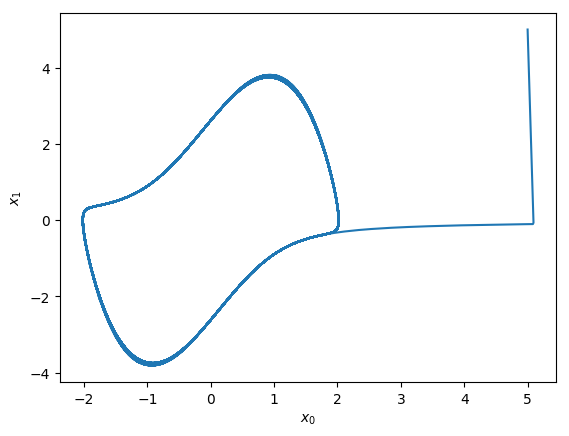

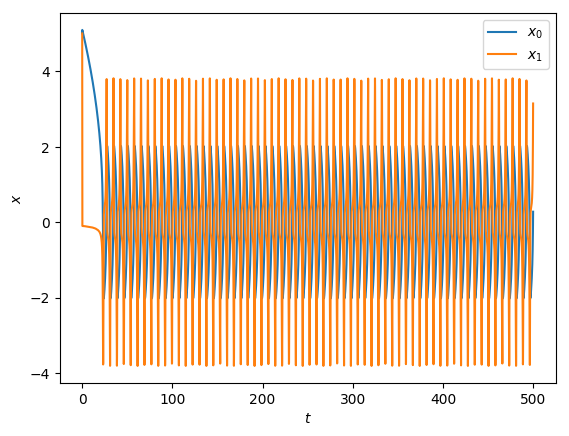

In [124]:
sol = vdp.integrate(tinit,tmax,dt,x0)
data_length =(sol.t).shape[0]
vdp.trajectory_plot()
vdp.evolution_plot()

Step 1b: Prepare data 

In [125]:
vdp_df = pd.DataFrame(data=(sol.y).T,    
                columns=['x','dx'])

#detrend 
vdp_df = vdp_df.diff()
vdp_df = vdp_df.dropna()

Step 2: Find optimal time lag and fit to VAR model

In [126]:
#create VAR object from data frame
model = VAR(vdp_df)

#find optimal lag order by information criteria
lag_orders_data = model.select_order(trend='nc')
print(lag_orders_data.selected_orders)

/usr/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


{'aic': 32, 'bic': 32, 'hqic': 32, 'fpe': 32}


In [127]:
#fit to optimal BIC lag number
#results = model.fit(lag_orders_data.selected_orders['aic'],trend='nc')
results = model.fit(lag_orders_data.selected_orders['bic'],trend='nc')

Step 3: Estimate Sigma, covariance of the noise, and estimate spectral density matrix

In [128]:
Sigma = np.cov((results.resid.values).T)
print(Sigma)

[[1.86652230e-07 4.94888558e-06]
 [4.94888558e-06 1.35019998e-04]]


In [129]:
def estimate_spectral_density(f):
    return estimate_spectral_density_matrix(f,Sigma,results.coefs)

Step 4: Compare spectral density matrix to estimated spectral density using Welch's method

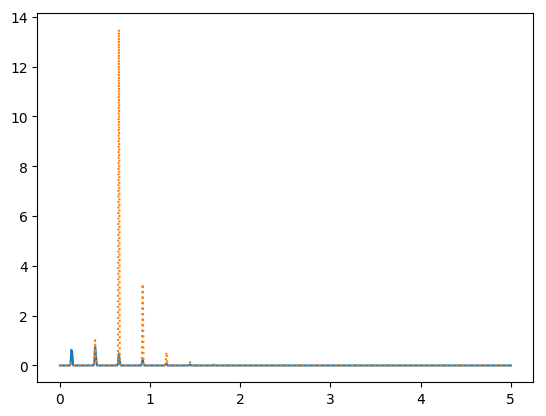

In [130]:
[f,csd_estimate_welch,csd_estimate_transfer] = \
        compare_spectrums('x','dx',vdp_df,estimate_spectral_density,1/dt)

plt.clf()
plt.plot(f,csd_estimate_welch)
plt.plot(f,csd_estimate_transfer,':')
plt.show()

Step 4: Repeat steps 2-3, varying lag length, so that estimated spectrums match

In [131]:
# time lag of 28 fits the trend of spectral density calculated via Welch's method
# Check if there are better estimates of spectral density besides Welch's method
results = model.fit(25,trend='nc')

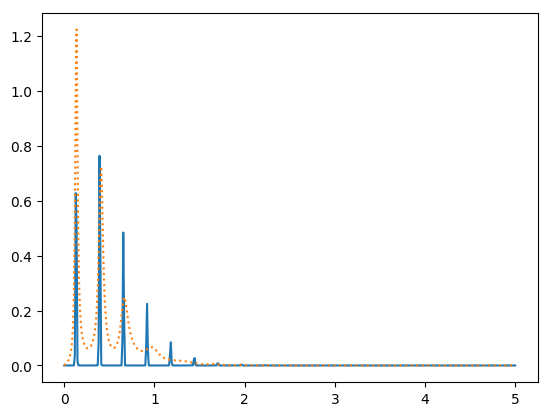

In [132]:
Sigma = np.cov((results.resid.values).T)
def estimate_spectral_density(f):
    return estimate_spectral_density_matrix(f,Sigma,results.coefs)
[f,csd_estimate_welch,csd_estimate_transfer] = \
        compare_spectrums('x','dx',vdp_df,estimate_spectral_density,1/dt)

plt.clf()
plt.plot(f,csd_estimate_welch)
plt.plot(f,csd_estimate_transfer,':')
plt.show()

# Van der Pool with noise added to the dynamical  data

Step 1a

In [133]:
x0 = np.array([5.0, 5.0])
dt = 0.1
tinit = 0
tmax = 150
vdp = dynamicalModels.van_der_pol(2)

sol = vdp.integrate(tinit,tmax,dt,x0)
data_length =(sol.t).shape

In [134]:
#add noise
length_vdp = sol.y[0,:].shape[0]
y = sol.y
y[0,:] = sol.y[0,:] + np.random.normal(scale=0.1,size=length_vdp)
y[1,:] = sol.y[1,:] = sol.y[1,:] + np.random.normal(scale=0.1,size=length_vdp)

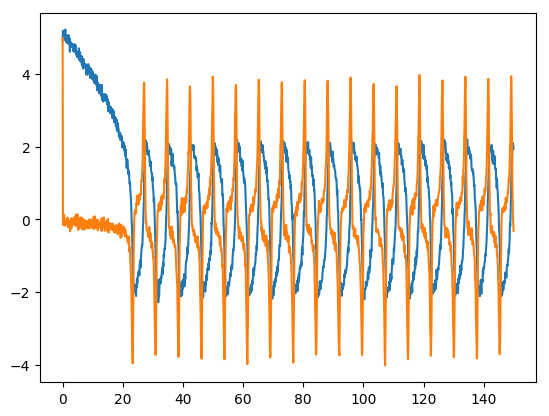

In [135]:
plt.plot(sol.t,y.T)
plt.show()

Step 1b: Prepare data

In [136]:
vdp_df = pd.DataFrame(data=y.T,    
                columns=['x','dx'])

#detrend 
vdp_df = vdp_df.diff()
vdp_df = vdp_df.dropna()

Step 2: Find optimal time lag and fit to VAR model

In [137]:
model = VAR(vdp_df)

#find optimal lag order by information criteria
lag_orders_data = model.select_order(trend='nc')
print(lag_orders_data.selected_orders)

{'aic': 24, 'bic': 13, 'hqic': 16, 'fpe': 24}


/usr/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [138]:
#fit to optimal BIC lag number
results = model.fit(lag_orders_data.selected_orders['bic'],trend='nc')

Step 3: Estimate Sigma, covariance of the noise, and estimate spectral density matrix

In [139]:
Sigma = np.cov((results.resid.values).T)
print(Sigma)

[[0.01327468 0.0030844 ]
 [0.0030844  0.05559954]]


In [140]:
def estimate_spectral_density(f):
    return estimate_spectral_density_matrix(f,Sigma,results.coefs)

Step 4: Compare spectral density matrix to estimated spectral density using Welch's method

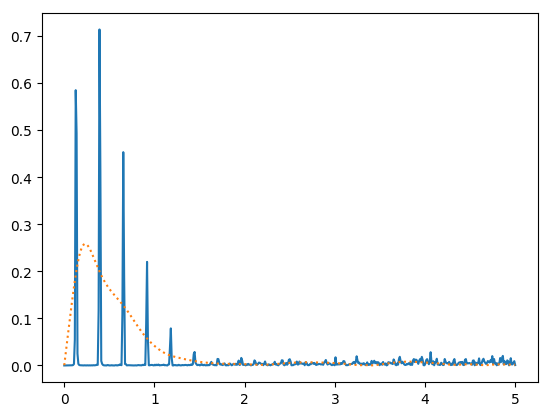

In [141]:
[f,csd_estimate_welch,csd_estimate_transfer] = \
        compare_spectrums('x','dx',vdp_df,estimate_spectral_density,1/dt)

plt.clf()
plt.plot(f,csd_estimate_welch)
plt.plot(f,csd_estimate_transfer,':')
plt.show()

Step 4: Repeat steps 2-3, varying lag length, so that estimated spectrums match

In [142]:
# time lag of 28 fits the trend of spectral density calculated via Welch's method
# Check if there are better estimates of spectral density besides Welch's method
results = model.fit(60,trend='nc')

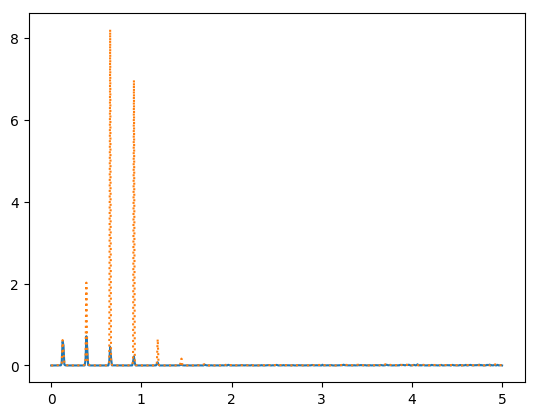

In [143]:
Sigma = np.cov((results.resid.values).T)
def estimate_spectral_density(f):
    return estimate_spectral_density_matrix(f,Sigma,results.coefs)
[f,csd_estimate_welch,csd_estimate_transfer] = \
        compare_spectrums('x','dx',vdp_df,estimate_spectral_density,1/dt)

plt.clf()
plt.plot(f,csd_estimate_welch)
plt.plot(f,csd_estimate_transfer,':')
plt.show()

# Weiner Process

Step 1a: Generate data

In [144]:
def a_fun(X):
    return (3-X)
def b_fun(X):
    return 1

#create four independently sample Weiner Process
sodes= dynamicalModels.sdes(a_fun,b_fun)
y = np.zeros([3,4000])
dt=0.1
tinit=0.0
tmax=20.0
N=4000
dt = (tinit-tmax)/(N-1)
for i in range(3): 
    x0 = 10*(2*np.random.uniform(size=1)-1)
    out = sodes.euler_maruyama(tinit,x0,tmax,N)
    y[i,:] = out[1]
t = out[0]

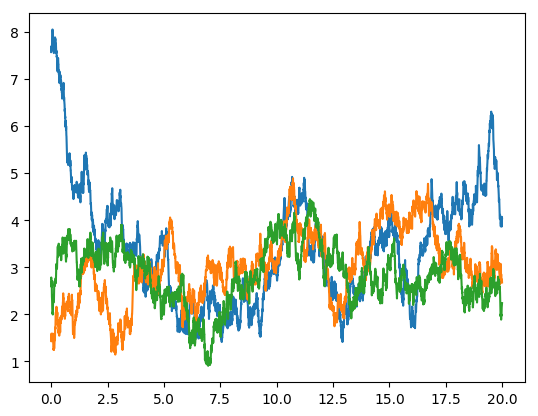

In [145]:
plt.plot(t,y.T)
plt.show()

Step 1b: Prepare data

In [146]:
wiener_df = pd.DataFrame(data=y.T,    
                columns=['x0','x1','x2'])

#detrend
wiener_df = wiener_df.diff()
wiener_df = wiener_df.dropna()

Step 2: Find optimal time lag and fit to VAR model

In [147]:
#find optimal lag order by information criteria
model = VAR(wiener_df)
lag_orders_data = model.select_order(trend='nc')
print(lag_orders_data.selected_orders)

/usr/local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


{'aic': 1, 'bic': 1, 'hqic': 1, 'fpe': 1}


In [148]:
#fit to optimal AIC lag number
results = model.fit(lag_orders_data.selected_orders['bic'],trend='nc')

Step 3: Estimate Sigma, covariance of the noise, and estimate spectral density matrix

In [149]:
Sigma = np.cov((results.resid.values).T)

In [150]:
def estimate_spectral_density(f):
    return estimate_spectral_density_matrix(f,Sigma,results.coefs)

Step 4: Compare spectral density matrix to estimated spectral density using Welch's method

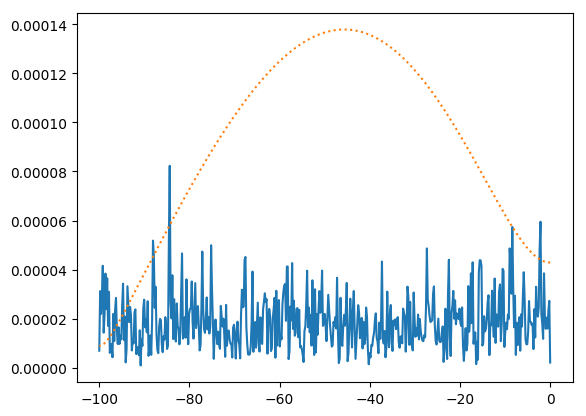

In [151]:
[f,csd_estimate_welch,csd_estimate_transfer] = \
        compare_spectrums('x0','x1',wiener_df,estimate_spectral_density,1/dt)

plt.clf()
plt.plot(f,csd_estimate_welch)
plt.plot(f,csd_estimate_transfer,':')
plt.show()

Step 4: Repeat steps 2-3, varying lag length, so that estimated spectrums match

In [152]:
# Check if there are better estimates of spectral density besides Welch's method
results = model.fit(30,trend='nc')

[[ 4.93317880e-03 -3.68987310e-05  7.08305852e-06]
 [-3.68987310e-05  5.01647858e-03 -5.10806808e-06]
 [ 7.08305852e-06 -5.10806808e-06  4.79677710e-03]]


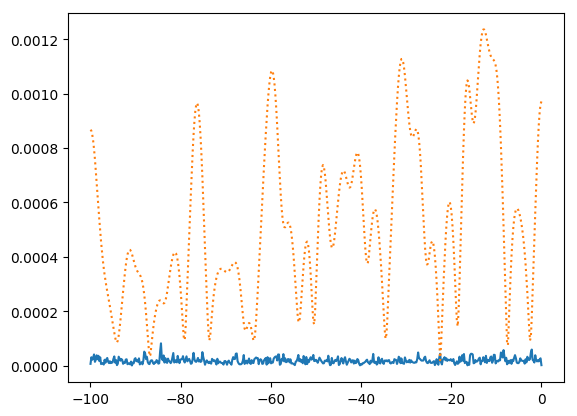

In [153]:
Sigma = np.cov((results.resid.values).T)
print(Sigma)
def estimate_spectral_density(f):
    return estimate_spectral_density_matrix(f,Sigma,results.coefs)
[f,csd_estimate_welch,csd_estimate_transfer] = \
        compare_spectrums('x0','x1',wiener_df,estimate_spectral_density,1/dt)

plt.clf()
plt.plot(f,csd_estimate_welch)
plt.plot(f,csd_estimate_transfer,':')
plt.show()